In [1]:
import math
import numpy as np
import copy
import matplotlib.pyplot as plt

import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

# Load the data

In [3]:
TRAIN_SIZE = 1500
VALID_SIZE = 250
TEST_SIZE = 250

BATCH_SIZE = 125

EPOCHS_MAX = 10

NUM_FEATURES = 28*28
NUM_CLASSES = 10

RANDOM_SEED = 1

In [4]:
dataset_train = MNIST('data', train=True, download=True, transform=ToTensor())
dataset_test = MNIST('data', train=False, download=True, transform=ToTensor())

In [5]:
dataset_training = torch.utils.data.Subset(dataset_train, range(0, TRAIN_SIZE))
#dataset_validating = torch.utils.data.Subset(dataset_test, range(0, VALID_SIZE))
dataset_testing = torch.utils.data.Subset(dataset_test, range(VALID_SIZE, VALID_SIZE + TEST_SIZE))

dataloader_train = DataLoader(dataset_training, batch_size=BATCH_SIZE, shuffle=True)
#dataloader_valid = DataLoader(dataset_validating, batch_size=BATCH_SIZE, shuffle=False)
dataloader_test = DataLoader(dataset_testing, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
torch.manual_seed(RANDOM_SEED)

# Define the model

RESNET-18 from https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/cnn/cnn-resnet18-mnist.ipynb

In [7]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

class BasicBlock(nn.Module):
    
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        
        super(BasicBlock, self).__init__()
        
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes):
        
        self.inplanes = 64
        in_dim = 1
        
        super(ResNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        
        downsample = None
        
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        
        return logits, probas

def resnet18(num_classes):
    """Constructs a ResNet-18 model."""
    model = ResNet(block=BasicBlock, layers=[2, 2, 2, 2], num_classes=num_classes)
    return model

In [8]:
def compute_accuracy(model, data_loader):
    
    correct_pred = 0
    num_examples = 0
    
    for i, (features, targets) in enumerate(data_loader):

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
        
    return correct_pred.float() / num_examples * 100

In [9]:
class FC(nn.Module):

    def __init__(self):

        super(FC, self).__init__()

        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)

    def forward(self, x):

        # The images are first flatten to vectors
        x = x.flatten(-3)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return F.log_softmax(x,dim=1)

In [10]:
def accuracy(x, y):

    x = x.detach().cpu().numpy()
    y = y.detach().cpu().numpy()
    
    return np.mean(np.argmax(x, axis=1) == y)

### Define the loss function

In [11]:
criterion = nn.CrossEntropyLoss()

### Workers

Inspiration from https://arxiv.org/pdf/1802.04434.pdf

In [12]:
class signumSGD_worker_resnet(optim.Optimizer):

    def __init__(self, params, lr=0.01, beta=0.1):

        self.beta = beta
        self.momentum = None

        defaults = dict(lr=lr)
        super(signumSGD_worker_resnet, self).__init__(params, defaults)

    def step(self):

        if self.momentum == None:
            self.momentum = [None for group in self.param_groups]
            
        signs = [[torch.zeros(p.size()) for p in group['params']] for group in self.param_groups]

        for i, group in enumerate(self.param_groups):
            
            if self.momentum[i] == None:
                self.momentum[i] = [torch.zeros(p.size()) for p in group["params"]]
                
            for j, p in enumerate(group['params']):
                
                if p.grad is None:
                    continue

                self.momentum[i][j] = self.beta * self.momentum[i][j] + (1 - self.beta) * p.grad
                signs[i][j] = torch.sign(self.momentum[i][j])
                
        return signs
            
    def update(self, signs):
            
        for i, group in enumerate(self.param_groups):
            for j, p in enumerate(group['params']):
                p.data -= group['lr'] * signs[i][j]

In [13]:
class worker_signum_resnet:
    
    def __init__(self, learning_rate, beta, batch):
        
        self.model = resnet18(NUM_CLASSES)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = signumSGD_worker_resnet(self.model.parameters(), lr=learning_rate, beta=beta)
        self.batch = batch
        
    def train(self):
        
        x,y = self.batch
        
        self.model.train()
        
        logits, probas = self.model.forward(x)
            
        loss = self.criterion(logits, y)
        loss.backward()

        signs = self.optimizer.step()
        self.optimizer.zero_grad()
        
        return signs, float(loss)
    
    def update(self, signs):
        self.optimizer.update(signs)

In [14]:
def evaluating_workers_resnet(learning_rate, beta, dataloader_train, dataloader_test, epochs=EPOCHS_MAX):
    
    # This is the server
    
    workers = []
    
    for it, batch in enumerate(dataloader_train):
         workers.append(worker_signum_resnet(learning_rate, beta, batch))
            
    M = len(workers)
    
    print("--> " + str(M) + " travailleurs")
            
    final_model = resnet18(NUM_CLASSES)
    criterion = nn.CrossEntropyLoss()
    optimizer = signumSGD_worker_resnet(final_model.parameters(), lr=learning_rate, beta=beta)
    
    losses = []
    accs = []
            
    for ep in range(epochs*M):
        
        # Training
        
        full_signs = None
        full_loss = 0
        
        for worker in workers:
            
            signs, loss = worker.train()
            
            if full_signs == None:
                full_signs = signs
            else:
                for i in range(len(full_signs)):
                    for j in range(len(full_signs[i])):
                        full_signs[i][j] = torch.add(full_signs[i][j], signs[i][j])
                        
            full_loss += loss
                
        # Update
        
        for i in range(len(full_signs)):
            for j in range(len(full_signs[i])):
                full_signs[i][j] = torch.sign(full_signs[i][j])
        
        for worker in workers:
            worker.update(full_signs)
        
        optimizer.update(full_signs)
        
        # Eval

        if (ep+1)%M == 0:
            
            final_model.eval()
        
            with torch.no_grad():
                acc = compute_accuracy(final_model, dataloader_test)

            print("Epoch {}/{} | Loss = {:.2f} & Acc = {:.1f}".format(ep+1, epochs*M, full_loss, acc))
            
            losses.append(full_loss)
            accs.append(acc)
        
    print("")
    
    return losses, accs, final_model

In [15]:
class signumSGD_worker_fc(optim.Optimizer):

    def __init__(self, params, lr=0.01, beta=0.1):

        self.beta = beta
        self.momentum = None

        defaults = dict(lr=lr)
        super(signumSGD_worker_fc, self).__init__(params, defaults)

    def step(self):

        if self.momentum == None:
            self.momentum = [None for group in self.param_groups]
            
        signs = [[torch.zeros(p.size()) for p in group['params']] for group in self.param_groups]

        for i, group in enumerate(self.param_groups):
            
            if self.momentum[i] == None:
                self.momentum[i] = [torch.zeros(p.size()) for p in group["params"]]
                
            for j, p in enumerate(group['params']):
                
                if p.grad is None:
                    continue

                self.momentum[i][j] = self.beta * self.momentum[i][j] + (1 - self.beta) * p.grad
                signs[i][j] = torch.sign(self.momentum[i][j])
                
        return signs
            
    def update(self, signs):
            
        for i, group in enumerate(self.param_groups):
            for j, p in enumerate(group['params']):
                p.data -= group['lr'] * signs[i][j]

In [23]:
class worker_signum_fc:
    
    def __init__(self, lr, beta, batch):
        
        self.model = FC()
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = signumSGD_worker_fc(self.model.parameters(), lr=lr, beta=beta)
        self.batch = batch
        
    def train(self):
        
        x,y = self.batch
        
        self.model.train()
        
        logits = self.model.forward(x)
            
        loss = self.criterion(logits, y)
        loss.backward()

        signs = self.optimizer.step()
        self.optimizer.zero_grad()
        
        return signs, float(loss)
    
    def update(self, signs):
        self.optimizer.update(signs)

In [17]:
def evaluating_workers_fc(learning_rate, beta, dataloader_train, dataloader_test, epochs=EPOCHS_MAX):
    
    # This is the server
    
    workers = []
    
    for it, batch in enumerate(dataloader_train):
         workers.append(worker_signum_fc(learning_rate, beta, batch))
            
    M = len(workers)
    
    print("--> " + str(M) + " travailleurs")
            
    final_model = FC()
    criterion = nn.CrossEntropyLoss()
    optimizer = signumSGD_worker_fc(final_model.parameters(), lr=learning_rate, beta=beta)
    
    losses = []
    accs = []
            
    for ep in range(epochs*M):
        
        # Training
        
        full_signs = None
        full_loss = 0
        
        for worker in workers:
            
            signs, loss = worker.train()
            
            if full_signs == None:
                full_signs = signs
            else:
                for i in range(len(full_signs)):
                    for j in range(len(full_signs[i])):
                        full_signs[i][j] = torch.add(full_signs[i][j], signs[i][j])
                        
            full_loss += loss
                
        # Update
        
        for i in range(len(full_signs)):
            for j in range(len(full_signs[i])):
                full_signs[i][j] = torch.sign(full_signs[i][j])
        
        for worker in workers:
            worker.update(full_signs)
        
        optimizer.update(full_signs)
        
        # Eval

        if (ep+1)%M == 0:
        
            final_model.eval()
            
            with torch.no_grad():
                
                acc_run = 0
                
                for it, batch in enumerate(dataloader_test):
                    x, y = batch
                    curr_bs = x.shape[0]
                    acc_run += accuracy(final_model(x), y) * curr_bs
                    
                acc = acc_run / len(dataloader_test.dataset) * 100
                
            print("Epoch {}/{} | Loss = {:.2f} & Acc = {:.1f}".format(ep+1, epochs*M, full_loss, acc))
            
            losses.append(full_loss)
            accs.append(acc)
        
    print("")
    
    return losses, accs, final_model

In [18]:
# Hyper-parameters
lr = 0.0001
beta = 0

losses_workers_sign_resnet, accs_workers_sign_resnet, model_workers_sign_resnet = evaluating_workers_resnet(lr, beta, dataloader_train, dataloader_test, EPOCHS_MAX)

--> 12 travailleurs
Epoch 12/120 | Loss = 4.00 & Acc = 7.2
Epoch 24/120 | Loss = 0.47 & Acc = 6.8
Epoch 36/120 | Loss = 0.08 & Acc = 8.0
Epoch 48/120 | Loss = 0.02 & Acc = 9.2
Epoch 60/120 | Loss = 0.00 & Acc = 10.4
Epoch 72/120 | Loss = 0.00 & Acc = 11.2
Epoch 84/120 | Loss = 0.00 & Acc = 11.2
Epoch 96/120 | Loss = 0.00 & Acc = 11.6
Epoch 108/120 | Loss = 0.00 & Acc = 11.6
Epoch 120/120 | Loss = 0.00 & Acc = 12.0



In [19]:
# Hyper-parameters
lr = 0.0001
beta = 0.9

losses_workers_signum_resnet, accs_workers_signum_resnet, model_workers_signum_resnet = evaluating_workers_resnet(lr, beta, dataloader_train, dataloader_test, EPOCHS_MAX)

--> 12 travailleurs
Epoch 12/120 | Loss = 4.76 & Acc = 8.0
Epoch 24/120 | Loss = 0.82 & Acc = 9.2
Epoch 36/120 | Loss = 0.21 & Acc = 8.0
Epoch 48/120 | Loss = 0.06 & Acc = 7.2
Epoch 60/120 | Loss = 0.02 & Acc = 5.6
Epoch 72/120 | Loss = 0.01 & Acc = 5.6
Epoch 84/120 | Loss = 0.00 & Acc = 5.6
Epoch 96/120 | Loss = 0.00 & Acc = 4.8
Epoch 108/120 | Loss = 0.00 & Acc = 4.4
Epoch 120/120 | Loss = 0.00 & Acc = 4.0



In [ ]:
# Hyper-parameters
lr = 0.005
beta = 0

losses_workers_sign_fc, accs_workers_sign_fc, model_workers_sign_fc = evaluating_workers_fc(lr, beta, dataloader_train, dataloader_test, EPOCHS_MAX)

--> 12 travailleurs
Epoch 12/120 | Loss = 21.35 & Acc = 29.6
Epoch 24/120 | Loss = 18.43 & Acc = 42.8
Epoch 36/120 | Loss = 11.78 & Acc = 50.8
Epoch 48/120 | Loss = 11.43 & Acc = 59.2
Epoch 60/120 | Loss = 14.94 & Acc = 52.4
Epoch 72/120 | Loss = 8.96 & Acc = 60.4
Epoch 84/120 | Loss = 7.31 & Acc = 75.6
Epoch 96/120 | Loss = 6.96 & Acc = 74.8
Epoch 108/120 | Loss = 9.59 & Acc = 74.0


In [26]:
# Hyper-parameters
lr = 0.01
beta = 0.9

losses_workers_signum_fc, accs_workers_signum_fc, model_workers_signum_fc = evaluating_workers_fc(lr, beta, dataloader_train, dataloader_test, EPOCHS_MAX)

--> 12 travailleurs
Epoch 12/120 | Loss = 13.60 & Acc = 54.8
Epoch 24/120 | Loss = 2.06 & Acc = 84.4
Epoch 36/120 | Loss = 1.08 & Acc = 86.4
Epoch 48/120 | Loss = 0.82 & Acc = 85.6
Epoch 60/120 | Loss = 4.36 & Acc = 85.2
Epoch 72/120 | Loss = 1.52 & Acc = 83.2
Epoch 84/120 | Loss = 0.93 & Acc = 86.0
Epoch 96/120 | Loss = 2.24 & Acc = 85.6
Epoch 108/120 | Loss = 0.58 & Acc = 86.0
Epoch 120/120 | Loss = 2.29 & Acc = 84.4



## Ploting

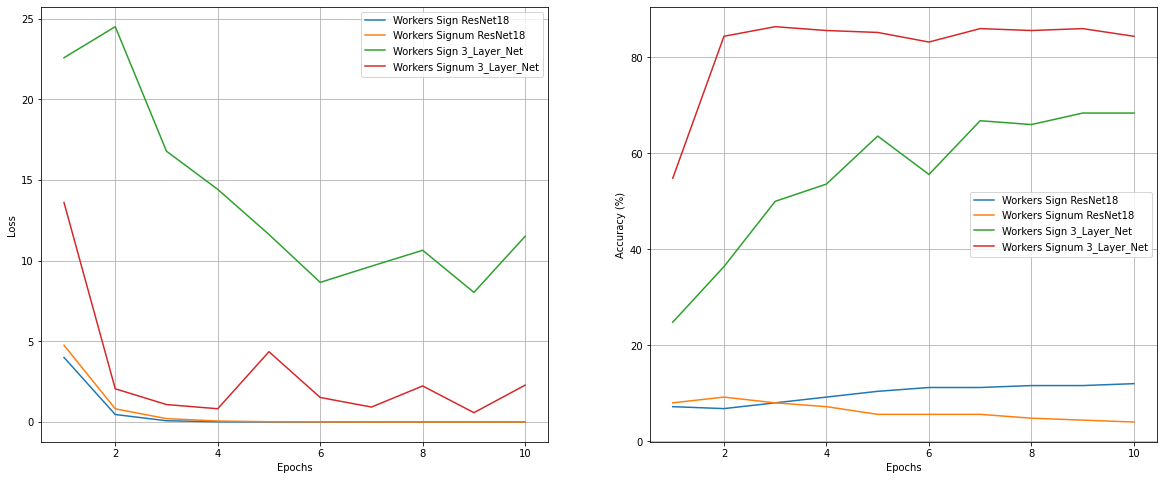

In [32]:
x = range(1, EPOCHS_MAX+1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

axes[0].plot(x, losses_workers_sign_resnet, label = "Workers Sign ResNet18")
axes[0].plot(x, losses_workers_signum_resnet, label = "Workers Signum ResNet18")
axes[0].plot(x, losses_workers_sign_fc, label = "Workers Sign 3_Layer_Net")
axes[0].plot(x, losses_workers_signum_fc, label = "Workers Signum 3_Layer_Net")

axes[0].set_ylabel("Loss")
axes[0].set_xlabel("Epochs")

axes[0].legend()
axes[0].grid()

axes[1].plot(x, accs_workers_sign_resnet, label = "Workers Sign ResNet18")
axes[1].plot(x, accs_workers_signum_resnet, label = "Workers Signum ResNet18")
axes[1].plot(x, accs_workers_sign_fc, label = "Workers Sign 3_Layer_Net")
axes[1].plot(x, accs_workers_signum_fc, label = "Workers Signum 3_Layer_Net")

axes[1].set_ylabel("Accuracy (%)")
axes[1].set_xlabel("Epochs")

axes[1].legend()
axes[1].grid()